# Outcome Analysis

## Housekeeping

We have to set up R before we change our working directory. This takes a few minutes because as we all know, efficiency is the mortal enemy of Colab. I believe there is a way to save packages to a zip and add them to the drive - I'll try to sort this out to speed up the process.

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
install.packages(c('survey', 'dplyr'))
library('survey')
library('dplyr')

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/survey_4.4-2.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/dplyr_1.1.4.tar.gz'

The downloaded source packages are in
	‘/tmp/RtmptvzjOR/downloaded_packages’
Loading required package: grid
Loading required package: Matrix
Loading required package: survival

Attaching package: ‘survey’

The following object is masked from ‘package:graphics’:

    dotchart


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
# If in colab, mount drive and set wd
# If local, set wd to parent of notebook
import os
import re

try:
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content/drive/MyDrive/ds1_nhanes/')
except:
  from pathlib import Path
  if not re.search(r'ds1_nhanes$', str(os.getcwd())):
    os.chdir(Path(os.getcwd()).parent)

print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ds1_nhanes


Packages needed for this notebook:

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Random forest things
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Trad stat things
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
if 'google.colab' in sys.modules:
  !pip install scikit_posthocs
import scikit_posthocs as sp

Loading dataset with cluster assignments (temporary at the time of writing):

In [3]:
df = pd.read_csv('data/clean/nhanes_2017_2023_clustered.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19386 entries, 0 to 19385
Data columns (total 60 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SEQN                       19386 non-null  int64  
 1   weight_2d                  19386 non-null  float64
 2   grams                      19386 non-null  float64
 3   satfat                     19386 non-null  float64
 4   monofat                    19386 non-null  float64
 5   polyfat                    19386 non-null  float64
 6   sodium                     19386 non-null  float64
 7   f_total_(cup_eq)           19386 non-null  float64
 8   f_citmlb_(cup_eq)          19386 non-null  float64
 9   f_other_(cup_eq)           19386 non-null  float64
 10  f_juice_(cup_eq)           19386 non-null  float64
 11  v_total_(cup_eq)           19386 non-null  float64
 12  v_drkgr_(cup_eq)           19386 non-null  float64
 13  v_redor_total_(cup_eq)     19386 non-null  flo

Check group counts:

In [4]:
df['cluster'].value_counts()

,count
cluster,
2,12377
3,3264
1,3115
0,630


Keep in mind that this is pretty uneven. Will affect some analyses.

## Demographics

### ANOVAS and Chi2

Start with categorical variables and Chi2:

In [5]:
cat_results = []

for demo in ['gender', 'race', 'education']:
  contingency = pd.crosstab(df[demo], df['cluster'])
  chi2, p, dof, expected = stats.chi2_contingency(contingency)
  cat_results.append([demo, '{:.3f}'.format(chi2), '{:.3f}'.format(p), dof])

# Put together in df
cat_results = pd.DataFrame(cat_results, columns=['Demo', 'Value', 'p', 'DoF'])

# Add stat identifier, format chi2 for latex
cat_results['Stat'] = '\(\chi^2\)'
cat_results = cat_results[['Demo', 'Stat', 'Value', 'DoF', 'p']]

# Format Demo column
cat_results['Demo'] = cat_results['Demo'].str.title()

cat_results


,Demo,Stat,Value,DoF,p
0,Gender,\(\chi^2\),727.245,3,0.000
1,Race,\(\chi^2\),163.273,12,0.000
2,Education,\(\chi^2\),2057.492,15,0.000


ANOVA with numeric variables:

In [6]:
num_results = []

# Not sure weighted least squares is what we actually wan there.
# Need survey package for PSUs
# for demo in ['age', 'income_ratio']:
#   lm = smf.wls(
#     f'{demo} ~ cluster',
#     data=df,
#     weights=df['weight_2d']
#   ).fit()
#   num_results.append(sm.stats.anova_lm(lm))

# Running unweighted for now
for demo in ['age', 'income_ratio']:
  lm = smf.ols(
    f'{demo} ~ cluster',
    data=df
  ).fit()
  num_results.append(sm.stats.anova_lm(lm))

# Put into a data frame
num_df = pd.concat(num_results, axis=0)

# Drop residual rows
num_df = num_df[~num_df['PR(>F)'].isna()]

# Add demo column
num_df['Demo'] = ['Age', 'Income Ratio']

# Add test identifier
num_df['Stat'] = 'F'

# Reorder
num_df = num_df[['Demo', 'Stat', 'F', 'df', 'PR(>F)']].reset_index(drop=True)

# Format column names
num_df.columns = ['Demo', 'Stat', 'Value', 'DoF', 'p']

# Reformat, add F to distinguish from Chi2
num_df['DoF'] = num_df['DoF'].astype(int)
num_df['Value'] = num_df['Value'].apply(lambda x: '{:.3f}'.format(x))
num_df['p'] = num_df['p'].apply(lambda x: '{:.3f}'.format(x))

num_df

,Demo,Stat,Value,DoF,p
0,Age,F,110.174,1,0.000
1,Income Ratio,F,73.869,1,0.000


Need to try a different method to get weights working

In [7]:
# Try posthoc test for ANOVA
age_ph = sp.posthoc_ttest(
    df,
    val_col='age',
    group_col='cluster',
    p_adjust='holm'
)

# Formatting
age_ph = age_ph.map(lambda x: '{:.3f}'.format(x))
print(f'Age:\n{age_ph}\n')

# For income
inc_ph = sp.posthoc_ttest(
    df,
    val_col='income_ratio',
    group_col='cluster',
    p_adjust='holm'
)

# Formatting
inc_ph = inc_ph.map(lambda x: '{:.3f}'.format(x))
print(f'Income:\n{inc_ph}\n')

Age:
       2      1      3      0
2  1.000  0.000  0.000  0.000
1  0.000  1.000  0.000  0.000
3  0.000  0.000  1.000  0.158
0  0.000  0.000  0.158  1.000

Income:
       2      1      3      0
2  1.000  0.000  0.000  0.000
1  0.000  1.000  0.000  0.000
3  0.000  0.000  1.000  0.044
0  0.000  0.000  0.044  1.000



Combine into one table and export to latex:

In [8]:
demo_table = pd.concat([cat_results, num_df], axis=0)
print(demo_table)
demo_table.to_latex(
    'outputs/checkin_3/analysis_demos.tex',
    index=False,
    label='tab:cluster_demo_tests',
    position='h',
    caption='Tests for differences in demographics among clusters'
)

           Demo        Stat     Value  DoF      p
0        Gender  \(\chi^2\)   727.245    3  0.000
1          Race  \(\chi^2\)   163.273   12  0.000
2     Education  \(\chi^2\)  2057.492   15  0.000
0           Age           F   110.174    1  0.000
1  Income Ratio           F    73.869    1  0.000


This is pretty hinky - it was showing all significant earlier, but now income ratio is far from it. I suppose it was a slightly different cluster outcome, but I'm skeptical it would have had such a huge swing. The F stat was like 10 before. Will have to poke around here.

### Graphs

In [9]:
weighted_demos = df.groupby(['cluster', 'race'], observed=True)['weight_2d'].sum().unstack(fill_value=0)
percent_demos = weighted_demos.div(weighted_demos.sum(axis=1), axis=0) * 100
print(percent_demos.round(1))

race     Black  Mexican American  Other Hispanic  Other or Multi  White
cluster                                                                
0          9.1               4.5             6.3             7.5   72.5
1          9.8              10.3             7.5            10.0   62.3
2         12.9               9.7            10.6            11.8   54.9
3         10.5               8.6             7.9            11.2   61.8


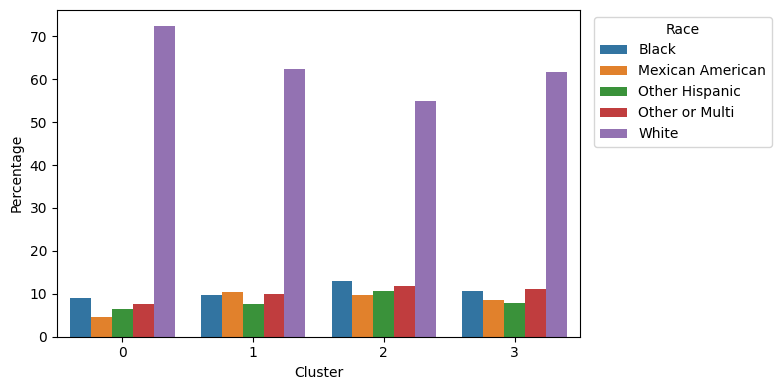

In [10]:
demos_long = percent_demos.reset_index().melt(
    id_vars='cluster',
    var_name='race',
    value_name='weight'
)
plt.figure(figsize=(6, 4))
ax = sns.barplot(
    data=demos_long,
    x='cluster',
    y='weight',
    hue='race'
)
ax.set(
  ylabel = 'Percentage',
  xlabel = 'Cluster'
)
ax.legend(title='Race')
plt.tight_layout()
sns.move_legend(ax, 'upper right', bbox_to_anchor=(1.38, 1))

plt.savefig('outputs/checkin_3/demos_race_clusters.png')
plt.show()


Income:

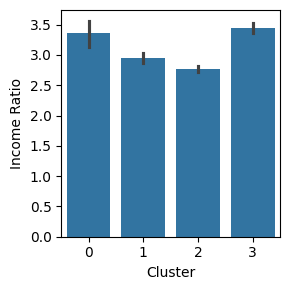

In [11]:
plt.figure(figsize=(3, 3))
ax = sns.barplot(
    data=df,
    x='cluster',
    y='income_ratio',
    weights='weight_2d'
)
ax.set(
  ylabel = 'Income Ratio',
  xlabel = 'Cluster'
)
plt.tight_layout()

plt.savefig('outputs/checkin_3/demos_income_clusters.png')
plt.show()

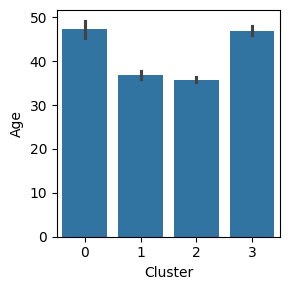

In [12]:
plt.figure(figsize=(3, 3))
ax = sns.barplot(
    data=df,
    x='cluster',
    y='age',
    weights='weight_2d'
)
ax.set(
  ylabel = 'Age',
  xlabel = 'Cluster'
)
plt.tight_layout()

plt.savefig('outputs/checkin_3/demos_age_clusters.png')
plt.show()


### Random Forest

Train test split workflow to see how well demographics predict cluster assignments. This isn't really a thing, and isn't really part of our research questions. But it's sorta neat

In [13]:
# Get df of demos and cluster only, set as X and y
dat = df[['cluster', 'age', 'education', 'income_ratio', 'gender', 'race']]
X = dat.drop(columns=['cluster'])
y = dat['cluster']

# Define variable types for preprocessing
cat_vars = ['education', 'gender', 'race']
num_vars = ['age', 'income_ratio']

# Split dataset, stratify by clusters to account for uneven groups
X_train, X_test, y_train, y_test = train_test_split(
  X,
  y,
  test_size=0.2,
  random_state=42,
  stratify=y
)

# Preprocess, one hot encoding for categorical variables
preprocess = ColumnTransformer(
  transformers=[
    ('num', StandardScaler(), num_vars),
    ('cat', OneHotEncoder(drop='first'), cat_vars)
  ]
)

# Create model
clf = RandomForestClassifier(
  n_estimators=100,
  max_features='sqrt',
  random_state=42
)

# Create processing pipeline
pipe = Pipeline([
  ('prep', preprocess),
  ('clf', clf)
])

# Fit model and get predictions
pipe.fit(X_train, y_train, clf__sample_weight=df.loc[y_train.index, 'weight_2d'])
y_pred = pipe.predict(X_test)

#### Confusion Matrix

Accuracy: 54.72%


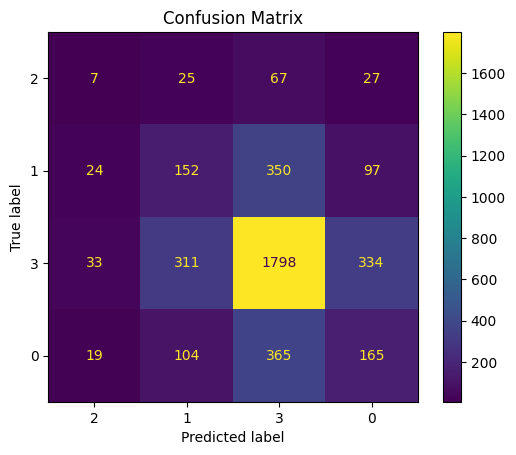

In [14]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

cm = confusion_matrix(y_test, y_pred)

display = ConfusionMatrixDisplay(
  confusion_matrix=cm,
  display_labels=df['cluster'].unique()
)
display.plot()
plt.title('Confusion Matrix')
plt.show()

Accuracy is not the worst thing ever because there are 4 groups. So it's better than random. And that's something, considering I wouldn't expect demographics to be THAT great of a predictor of these clusters.

Seemingly needlessly complicated way to get a normalized plot. Here is [source](https://www.geeksforgeeks.org/how-to-plot-confusion-matrix-with-labels-in-sklearn/).

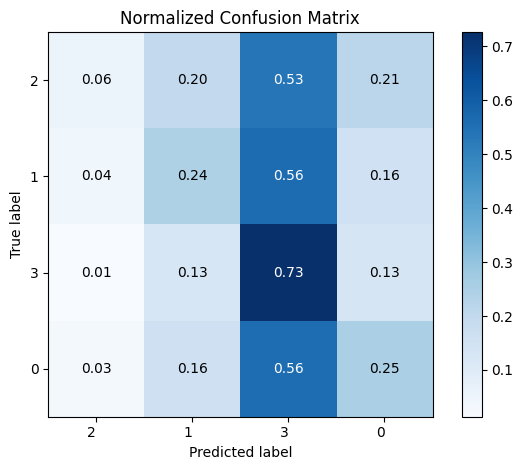

In [15]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=df['cluster'].unique(),
    yticklabels=df['cluster'].unique(),
    title='Normalized Confusion Matrix',
    ylabel='True label',
    xlabel='Predicted label'
)

plt.setp(
    ax.get_xticklabels(),
    ha="right",
    rotation_mode="anchor"
)

fmt = '.2f'
thresh = cm_normalized.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm_normalized[i, j], fmt),
                ha="center", va="center",
                color="white" if cm_normalized[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

#### Feature Importance

In [16]:
# Get feature names out of our pipe
feature_names = pipe.named_steps['prep'].get_feature_names_out()
print(feature_names)
print(len(feature_names))

# Pull out feature importances
importances = clf.feature_importances_

# Get indices for descending order of importances
indices = np.argsort(importances)

['num__age' 'num__income_ratio' 'cat__education_College graduate or above'
 "cat__education_Don't know" 'cat__education_High school/GED'
 'cat__education_Less than 9th grade' 'cat__education_Some college or AA'
 'cat__gender_Male' 'cat__race_Mexican American'
 'cat__race_Other Hispanic' 'cat__race_Other or Multi' 'cat__race_White']
12


Text(0, 0.5, 'Features')

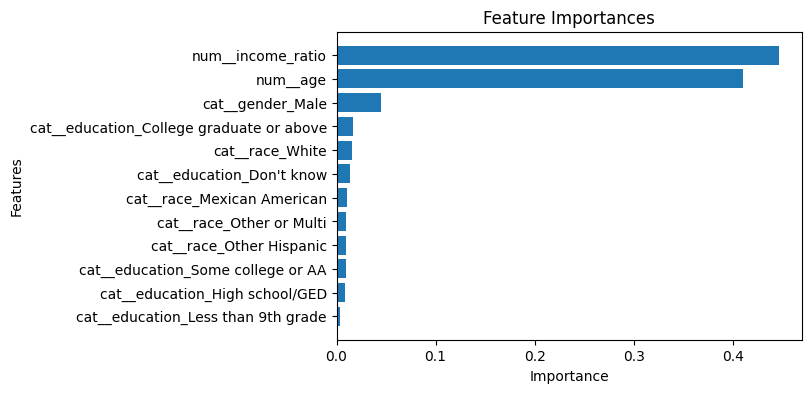

In [17]:
# Plot, arranging features in same order as indices
plt.figure(figsize=(6, 4))
plt.title("Feature Importances")
plt.barh(feature_names[indices], importances[indices])
plt.xlabel("Importance")
plt.ylabel("Features")


Don't much like how the one-hot encoding persists into here. Let's try adding together each of the importances for the categorical variables. Not entirely sure this is kosher but we're doing it.

In [18]:
# Get df of features and importances
imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Combine importances for gender, education, race
for demo in ['gender', 'education', 'race']:
  out = imp_df.loc[imp_df['feature'].str.contains(demo), 'importance'].sum()
  imp_df.loc[len(imp_df)] = [demo, out]

# Drop rows that contain 'cat'
imp_df = imp_df[~imp_df['feature'].str.contains('^cat')]

# remove prefix num__
imp_df['feature'] = imp_df['feature'].str.replace('num__', '')

# Arrange by importance
imp_df = imp_df.sort_values(by='importance', ascending=False)

# Features in title case
imp_df['feature'] = imp_df['feature'].str.title().str.replace('_', ' ')
print(imp_df)

         feature  importance
1   Income Ratio    0.447008
0            Age    0.409996
13     Education    0.052403
14          Race    0.045582
12        Gender    0.045012


Text(0, 0.5, 'Features')

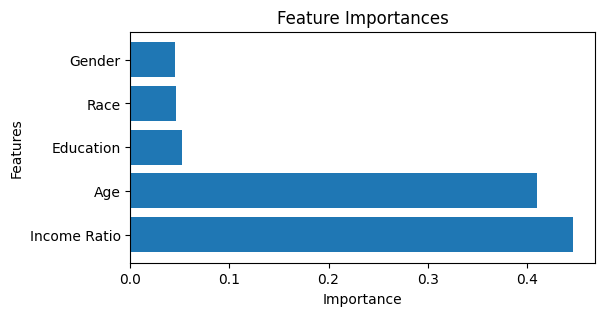

In [19]:
# Plot cleaner feature importance
plt.figure(figsize=(6, 3))
plt.title("Feature Importances")
plt.barh(imp_df['feature'], imp_df['importance'])
plt.xlabel("Importance")
plt.ylabel("Features")

Kinda neat. Probably not worth including. But kinda neat

## R Magic

Note that we need to start this script from the top so we set up R magic first.

### Load and Wrangle Data

In [4]:
%%R
dat <- read.csv('data/clean/nhanes_2017_2023_clustered.csv')
str(dat)

'data.frame':	19386 obs. of  60 variables:
 $ SEQN                     : int  109263 109264 109265 109266 109269 109270 109271 109272 109273 109274 ...
 $ weight_2d                : num  8904 3627 17806 2994 9116 ...
 $ grams                    : num  2828 4177 4082 9867 1906 ...
 $ satfat                   : num  26.9 34.2 58.9 44.3 26.1 ...
 $ monofat                  : num  22.7 39.3 45.7 45.5 30.3 ...
 $ polyfat                  : num  13.1 25.9 29.3 32 32 ...
 $ sodium                   : num  3846 4390 3982 5440 3007 ...
 $ f_total_.cup_eq.         : num  3.75 0 5.515 2.0505 0.0991 ...
 $ f_citmlb_.cup_eq.        : num  0 0 1.04 1.68 0 ...
 $ f_other_.cup_eq.         : num  0 0 1.004 0.373 0 ...
 $ f_juice_.cup_eq.         : num  3.75 0 3.472 0 0.0991 ...
 $ v_total_.cup_eq.         : num  0.715 3.106 1.379 4.103 0.351 ...
 $ v_drkgr_.cup_eq.         : num  0 0.6887 0.0504 0.0709 0 ...
 $ v_redor_total_.cup_eq.   : num  0.296 0.308 0.253 0.653 0.176 ...
 $ v_redor_tomato_.cup_eq.

Do some cleaning to prepare to create survey design object

In [5]:
%%R
# Remove irrelevant columns
dat <- select(
    dat,
    psu,
    strata,
    weight_2d,
    gender:cluster
)

# Make characters factors, split age into bins
dat <- dat %>%
  mutate(
    gender = factor(gender),
    education = factor(education),
    race = factor(race),
    cluster = factor(cluster),
    age_bin = cut(
      age,
      breaks = c(-Inf, 19, 29, 39, 49, 59, Inf),
      labels = c(
        "<20",
        "20-29",
        "30-39",
        "40-49",
        "50-59",
        "60+"
      )
    )
  )
str(dat)

'data.frame':	19386 obs. of  14 variables:
 $ psu              : int  3 1 1 2 2 1 1 1 1 2 ...
 $ strata           : int  156 155 157 168 152 150 167 155 155 167 ...
 $ weight_2d        : num  8904 3627 17806 2994 9116 ...
 $ gender           : Factor w/ 2 levels "Female","Male": 2 1 2 1 2 1 2 2 2 2 ...
 $ age              : num  2 13 2 29 2 ...
 $ race             : Factor w/ 5 levels "Black","Mexican American",..: 4 2 5 4 3 1 5 2 5 4 ...
 $ education        : Factor w/ 6 levels "9th to 11th grade",..: 3 3 3 2 3 3 1 3 6 6 ...
 $ income_ratio     : num  4.66 0.83 3.06 5 0.96 1.88 0.53 0.73 0.83 1.2 ...
 $ total_cholesterol: int  120 166 174 195 136 103 147 153 164 105 ...
 $ blood_mercury    : num  0.64 0.2 0.2 0.36 0.2 0.2 0.42 0.2 0.51 0.2 ...
 $ avg_systolic_bp  : num  118.7 108 90.3 99 103.3 ...
 $ avg_diastolic_bp : num  60.3 67 52.3 54.3 68.3 ...
 $ cluster          : Factor w/ 4 levels "0","1","2","3": 3 3 3 3 3 2 2 3 3 4 ...
 $ age_bin          : Factor w/ 6 levels "<20","20-29"

### Survey Design Object

This takes all the relics of our complex survey design and will incorporate it into any analyses. We will then use this 'design' object as the dataset for everything.

In [36]:
%%R
design <- svydesign(
  data = dat,
  id =  ~ psu,
  strata =  ~ strata,
  weights =  ~ weight_2d,
  nest = TRUE
)

### Summary Stats

Even taking the mean of a variable depends on the study design. We get a point estimate as well as a standard error for everything.

In [37]:
%%R
# Summary stats with R survey
print(svyby(~blood_mercury, ~cluster, design, svymean, na.rm = TRUE))
print(svyby(~avg_systolic_bp, ~cluster, design, svymean, na.rm = TRUE))
print(svyby(~avg_diastolic_bp, ~cluster, design, svymean, na.rm = TRUE))
print(svyby(~total_cholesterol, ~cluster, design, svymean, na.rm = TRUE))

  cluster blood_mercury         se
0       0     1.7437266 0.14602411
1       1     0.7757520 0.04632142
2       2     0.8795586 0.03550191
3       3     1.4512629 0.06680525
  cluster avg_systolic_bp        se
0       0        126.1320 0.9229768
1       1        116.7970 0.5117709
2       2        114.6038 0.2940248
3       3        119.6819 0.4437921
  cluster avg_diastolic_bp        se
0       0         77.99105 0.7005691
1       1         71.39219 0.3821271
2       2         69.62142 0.1656500
3       3         72.33253 0.2758454
  cluster total_cholesterol        se
0       0          197.9381 2.5624559
1       1          177.2396 1.0773527
2       2          177.5510 0.9470897
3       3          185.8445 1.2196444


Can break it down further with more variables, use these for graphs.

In [38]:
%%R
table <- svyby(~total_cholesterol, ~cluster + gender, design, svymean, na.rm = TRUE)
print(table)

         cluster gender total_cholesterol       se
0.Female       0 Female          198.7638 3.937843
1.Female       1 Female          181.9220 1.492870
2.Female       2 Female          181.5966 1.012066
3.Female       3 Female          191.0443 1.636626
0.Male         0   Male          197.6608 3.402234
1.Male         1   Male          174.9833 1.300372
2.Male         2   Male          171.0096 1.302344
3.Male         3   Male          181.3592 1.597640


### Handoff to Python

Hand off the R object back to python so we can make graphs or latex tables of whatever:

In [ ]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

r_table = pandas2ri.rpy2py(robjects.globalenv['table'])
r_table

,cluster,gender,total_cholesterol,se
0.Female,1,1,198.763833,3.937843
1.Female,2,1,181.921972,1.492870
2.Female,3,1,181.596603,1.012066
3.Female,4,1,191.044336,1.636626
0.Male,1,2,197.660821,3.402234
1.Male,2,2,174.983255,1.300372
2.Male,3,2,171.009565,1.302344
3.Male,4,2,181.359223,1.597640


### ANOVA

GLM with continuous y and categorical x is equivalent to ANOVA

In [ ]:
%%R
summary(svyglm(blood_mercury ~ cluster, design))


Call:
svyglm(formula = blood_mercury ~ cluster, design = design)

Survey design:
svydesign(data = dat, id = ~psu, strata = ~strata, weights = ~weight_2d, 
    nest = TRUE)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.7437     0.1460  11.941 2.95e-14 ***
cluster1     -0.9680     0.1411  -6.858 4.39e-08 ***
cluster2     -0.8642     0.1434  -6.027 5.77e-07 ***
cluster3     -0.2925     0.1414  -2.068   0.0456 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 2.571778)

Number of Fisher Scoring iterations: 2



In addition: Warning messages:
1: In summary.glm(g) :
  observations with zero weight not used for calculating dispersion
2: In summary.glm(glm.object) :
  observations with zero weight not used for calculating dispersion


Shows differences in mean of blood mercury among clusters

### GLM

Can do linear, logistic, poisson, etc., and include covariates here

In [ ]:
%%R
model <- svyglm(blood_mercury ~ cluster + age + education + race + gender, design)
print(summary(model))


Call:
svyglm(formula = blood_mercury ~ cluster + age + education + 
    race + gender, design = design)

Survey design:
svydesign(data = dat, id = ~psu, strata = ~strata, weights = ~weight_2d, 
    nest = TRUE)

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         0.848532   0.167847   5.055 2.90e-05 ***
cluster1                           -0.775424   0.133101  -5.826 3.86e-06 ***
cluster2                           -0.631609   0.142233  -4.441 0.000147 ***
cluster3                           -0.354810   0.141954  -2.499 0.019080 *  
age                                 0.011055   0.001442   7.666 3.90e-08 ***
educationCollege graduate or above  0.828781   0.089459   9.264 1.02e-09 ***
educationDon't know                 0.153867   0.084405   1.823 0.079829 .  
educationHigh school/GED            0.089671   0.061580   1.456 0.157314    
educationLess than 9th grade        0.415622   0.162049   2.565 0.016445 *  
edu

In addition: Warning messages:
1: In summary.glm(g) :
  observations with zero weight not used for calculating dispersion
2: In summary.glm(glm.object) :
  observations with zero weight not used for calculating dispersion


In [ ]:
%%R
# Run another model with income, then compare
model2 <- svyglm(blood_mercury ~ cluster + age + education + race + gender + income_ratio, design)

# Compare with anova
print(anova(model, model2))
# model2 is better

# Print confidence intervals
print(confint(model2))

Working (Rao-Scott+F) LRT for income_ratio
 in svyglm(formula = blood_mercury ~ cluster + age + education + 
    race + gender + income_ratio, design = design)
Working 2logLR =  61.21496 p= 3.9101e-08 
df=1;  denominator df= 25
                                          2.5 %      97.5 %
(Intercept)                         0.407118138  1.10029308
cluster1                           -1.037798641 -0.47740988
cluster2                           -0.907010513 -0.31310198
cluster3                           -0.657030945 -0.06131353
age                                 0.007319619  0.01322324
educationCollege graduate or above  0.452673887  0.78180209
educationDon't know                -0.119183491  0.19781285
educationHigh school/GED           -0.083818245  0.14974243
educationLess than 9th grade        0.105433156  0.75508506
educationSome college or AA         0.052130788  0.27218791
raceMexican American               -0.261764480  0.05137962
raceOther Hispanic                 -0.137323062  0.1

In addition: Warning messages:
1: In summary.glm(g) :
  observations with zero weight not used for calculating dispersion
2: In summary.glm(glm.object) :
  observations with zero weight not used for calculating dispersion
3: In summary.glm(g) :
  observations with zero weight not used for calculating dispersion
4: In summary.glm(glm.object) :
  observations with zero weight not used for calculating dispersion


## PBP Consumption Analysis

### Weighted and Unweighted Means: PBP Consumption

In [ ]:
from IPython.display import display

# Unweighted means

means_table = df.groupby('cluster')[['pf_soy_(oz_eq)','pf_legumes_(oz_eq)', 'pf_nutsds_(oz_eq)']].mean()

display(means_table.round(4))

# Weighted means

def weighted_mean(x, value_col, weight_col):
    return (x[value_col] * x[weight_col]).sum() / x[weight_col].sum()

weighted_means = df.groupby('cluster').apply(
    lambda g: pd.Series({
        'wt_mean_pf_soy_(oz_eq)': weighted_mean(g, 'pf_soy_(oz_eq)', 'weight_2d'),
        'wt_mean_pf_legumes_(oz_eq)': weighted_mean(g, 'pf_legumes_(oz_eq)', 'weight_2d'),
        'wt_mean_pf_nutsds_(oz_eq)': weighted_mean(g, 'pf_nutsds_(oz_eq)', 'weight_2d')
    })
).reset_index()

display(weighted_means.round(4))

,pf_soy_(oz_eq),pf_legumes_(oz_eq),pf_nutsds_(oz_eq)
cluster,,,
0,0.1152,0.9319,1.4368
1,0.1448,0.8667,1.3423
2,0.0964,0.5209,0.6442
3,0.2567,1.4001,2.9415


<ipython-input-20-e631b68a648e>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_means = df.groupby('cluster').apply(


,cluster,wt_mean_pf_soy_(oz_eq),wt_mean_pf_legumes_(oz_eq),wt_mean_pf_nutsds_(oz_eq)
0,0,0.1834,0.8879,1.5341
1,1,0.1551,0.8593,1.5140
2,2,0.1213,0.5833,0.7800
3,3,0.2853,1.3574,3.2220


### Descriptive Statistics

In [ ]:
# Descriptive Stats: Unweighted Soy Consumption by Cluster

descriptive_unweighted = df.groupby('cluster')['pf_soy_(oz_eq)'].describe()
print(descriptive_unweighted.round(4))

           count    mean     std  min  25%  50%    75%      max
cluster                                                        
0          630.0  0.1152  0.4901  0.0  0.0  0.0  0.000   4.1992
1         3115.0  0.1448  0.6227  0.0  0.0  0.0  0.004  16.3886
2        12377.0  0.0964  0.4783  0.0  0.0  0.0  0.000  15.0528
3         3264.0  0.2567  1.0082  0.0  0.0  0.0  0.000  26.6560


In [ ]:
# Descriptive Stats: Unweighted Legume Consumption by Cluster

descriptive_unweighted = df.groupby('cluster')['pf_legumes_(oz_eq)'].describe()
print(descriptive_unweighted.round(4))

           count    mean     std  min  25%  50%     75%      max
cluster                                                         
0          630.0  0.9319  2.1532  0.0  0.0  0.0  0.7875  19.9343
1         3115.0  0.8667  2.0057  0.0  0.0  0.0  0.7200  23.8160
2        12377.0  0.5209  1.3869  0.0  0.0  0.0  0.0000  23.8160
3         3264.0  1.4001  2.9646  0.0  0.0  0.0  1.7030  29.7741


In [ ]:
# Descriptive Stats: Unweighted Nuts & Seeds Consumption by Cluster

descriptive_unweighted = df.groupby('cluster')['pf_nutsds_(oz_eq)'].describe()
print(descriptive_unweighted.round(4))

           count    mean     std  min  25%     50%     75%      max
cluster                                                            
0          630.0  1.4368  2.9667  0.0  0.0  0.0000  1.6446  21.2297
1         3115.0  1.3423  2.6577  0.0  0.0  0.1548  1.6834  32.0215
2        12377.0  0.6442  1.4127  0.0  0.0  0.0000  0.5999  19.9430
3         3264.0  2.9415  4.9006  0.0  0.0  0.8630  3.9928  65.8470


In [ ]:
#Descriptive Stats: Weighted Soy Consumption by Cluster

desc_weighted = df.groupby('cluster').apply(
    lambda g: pd.Series({
        'weighted_mean': weighted_mean(g, 'pf_soy_(oz_eq)', 'weight_2d'),
        'weighted_std': weighted_std(g, 'pf_soy_(oz_eq)', 'weight_2d'),
        'min': g['pf_soy_(oz_eq)'].min(),
        '25%': g['pf_soy_(oz_eq)'].quantile(0.25),
        'median': g['pf_soy_(oz_eq)'].median(),
        '75%': g['pf_soy_(oz_eq)'].quantile(0.75),
        'max': g['pf_soy_(oz_eq)'].max(),
    })
).reset_index()

print(desc_weighted.round(3).to_string(index=False))

NameError: name 'weighted_std' is not defined

In [ ]:
#Descriptive Stats: Weighted Legume Consumption by Cluster

desc_weighted = df.groupby('cluster').apply(
    lambda g: pd.Series({
        'weighted_mean': weighted_mean(g, 'pf_legumes_(oz_eq)', 'weight_2d'),
        'weighted_std': weighted_std(g, 'pf_legumes_(oz_eq)', 'weight_2d'),
        'min': g['pf_legumes_(oz_eq)'].min(),
        '25%': g['pf_legumes_(oz_eq)'].quantile(0.25),
        'median': g['pf_legumes_(oz_eq)'].median(),
        '75%': g['pf_legumes_(oz_eq)'].quantile(0.75),
        'max': g['pf_legumes_(oz_eq)'].max(),
    })
).reset_index()

print(desc_weighted.round(3).to_string(index=False))

In [ ]:
#Descriptive Stats: Weighted Nuts & Seeds Consumption by Cluster

desc_weighted = df.groupby('cluster').apply(
    lambda g: pd.Series({
        'weighted_mean': weighted_mean(g, 'pf_nutsds_(oz_eq)', 'weight_2d'),
        'weighted_std': weighted_std(g, 'pf_nutsds_(oz_eq)', 'weight_2d'),
        'min': g['pf_nutsds_(oz_eq)'].min(),
        '25%': g['pf_nutsds_(oz_eq)'].quantile(0.25),
        'median': g['pf_nutsds_(oz_eq)'].median(),
        '75%': g['pf_nutsds_(oz_eq)'].quantile(0.75),
        'max': g['pf_nutsds_(oz_eq)'].max(),
    })
).reset_index()

print(desc_weighted.round(3).to_string(index=False))